In [1]:
import pandas as pd
import numpy as np
import glob
import pytz
import os
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Load in Data
EVENTS_FOLDER = '../../data/bishkek_csr/03_train_ready/event_exports' 
RESPECK_FOLDER = '../../data/bishkek_csr/03_train_ready/respeck'
NASAL_FOLDER = '../../data/bishkek_csr/03_train_ready/nasal_files'

# --- Define relevant events ---
APNEA_EVENT_LABELS = [
    'Obstructive Apnea'
]

all_sessions_df_list = []
event_files = glob.glob(os.path.join(EVENTS_FOLDER, '*_event_export.csv'))

if not event_files:
    raise FileNotFoundError(f"No event files found in '{EVENTS_FOLDER}'.")

print(f"Found {len(event_files)} event files. Processing each one...")

for event_file_path in event_files:
    # --- 1. Setup paths and IDs ---
    base_name = os.path.basename(event_file_path)
    session_id = base_name.split('_event_export.csv')[0]
    respeck_file_path = os.path.join(RESPECK_FOLDER, f'{session_id}_respeck.csv')
    nasal_file_path = os.path.join(NASAL_FOLDER, f'{session_id}_nasal.csv')
    
    if not all(os.path.exists(p) for p in [respeck_file_path, nasal_file_path]):
        print(f"  - WARNING: Skipping session '{session_id}'. A corresponding file is missing.")
        continue
    print(f"  - Processing session: {session_id}")
    
    # --- 2. Load CORE data sources ---
    df_events = pd.read_csv(event_file_path, decimal=',')
    df_nasal = pd.read_csv(nasal_file_path)
    df_respeck = pd.read_csv(respeck_file_path)

    # --- 3. Standardize timestamp columns and types ---
    df_events.rename(columns={'UnixTimestamp': 'timestamp_unix'}, inplace=True)
    df_nasal.rename(columns={'UnixTimestamp': 'timestamp_unix'}, inplace=True, errors='ignore')
    df_respeck.rename(columns={'alignedTimestamp': 'timestamp_unix'}, inplace=True)
    
    for df_ in [df_events, df_nasal, df_respeck]:
        df_['timestamp_unix'] = pd.to_numeric(df_['timestamp_unix'], errors='coerce')
        df_.dropna(subset=['timestamp_unix'], inplace=True)
        df_['timestamp_unix'] = df_['timestamp_unix'].astype('int64')

    # --- 4. Calculate the true overlapping time range ---
    start_time = max(df_nasal['timestamp_unix'].min(), df_respeck['timestamp_unix'].min())
    end_time = min(df_nasal['timestamp_unix'].max(), df_respeck['timestamp_unix'].max())
    
    # --- 5. Trim Respeck data to the overlapping time range ---
    df_respeck = df_respeck[(df_respeck['timestamp_unix'] >= start_time) & (df_respeck['timestamp_unix'] <= end_time)].copy()

    if df_respeck.empty:
        print(f"  - WARNING: Skipping session '{session_id}'. No Respeck data in the overlapping range.")
        continue
        
    # --- 6. Precise Interval-Based Labeling using Duration ---
    print(f"  - Applying precise interval-based labels...")
    df_respeck['Label'] = 0
    df_events['Duration_ms'] = (df_events['Duration'] * 1000).astype('int64')
    df_events['end_time_unix'] = df_events['timestamp_unix'] + df_events['Duration_ms']
    df_apnea_events = df_events[df_events['Event'].isin(APNEA_EVENT_LABELS)].copy()

    for index, event in df_apnea_events.iterrows():
        start_event = event['timestamp_unix']
        end_event = event['end_time_unix']
        df_respeck.loc[df_respeck['timestamp_unix'].between(start_event, end_event), 'Label'] = 1

    # --- 7. Finalize session data ---
    df_respeck['SessionID'] = session_id
    all_sessions_df_list.append(df_respeck)

# --- Combine all nights and perform final processing ---
if not all_sessions_df_list:
    raise ValueError("Processing failed. No data was loaded.")

df = pd.concat(all_sessions_df_list, ignore_index=True)

print("\n----------------------------------------------------")
print("Data loading with PURE signals complete.")
print(f"Final DataFrame shape: {df.shape}")
print(f"Final class distribution in raw data: \n{df['Label'].value_counts(normalize=True)}")

Found 9 event files. Processing each one...
  - Processing session: 26-04-2025
  - Applying precise interval-based labels...
  - Processing session: 08-05-2025
  - Applying precise interval-based labels...
  - Processing session: 05-04-2025
  - Applying precise interval-based labels...
  - Processing session: 10-05-2025
  - Applying precise interval-based labels...
  - Processing session: 24-04-2025
  - Applying precise interval-based labels...
  - Processing session: 25-04-2025
  - Applying precise interval-based labels...
  - Processing session: 16-04-2025
  - Applying precise interval-based labels...
  - Processing session: 11-05-2025
  - Applying precise interval-based labels...
  - Processing session: 04-04-2025
  - Applying precise interval-based labels...

----------------------------------------------------
Data loading with PURE signals complete.
Final DataFrame shape: (2139235, 14)
Final class distribution in raw data: 
Label
0    0.988052
1    0.011948
Name: proportion, dtyp

In [3]:
# Windowing: Creating the time-series segments.
print(df.columns)

SAMPLING_RATE_HZ = 12.5
WINDOW_DURATION_SEC = 30
WINDOW_SIZE = int(WINDOW_DURATION_SEC * SAMPLING_RATE_HZ)

# Step size for sliding window. An 80% overlap is a good start.
OVERLAP_PERCENTAGE = 0.80
STEP_SIZE = int(WINDOW_SIZE * (1 - OVERLAP_PERCENTAGE))

# === Data Parameters ===
FEATURE_COLUMNS = [
    'breathingSignal', 
    'activityLevel',
    'breathingRate', # This is now a time-varying signal (after imputation)
    'x',             # Raw accelerometer data
    'y',             # Raw accelerometer data
    'z'     
]
LABEL_COLUMN = 'Label' 
SESSION_ID_COLUMN = 'SessionID'


TEST_NIGHTS = 2
TOTAL_NIGHTS = 9 
TEST_SIZE = TEST_NIGHTS / TOTAL_NIGHTS

RANDOM_STATE = 42
EPOCHS = 50
BATCH_SIZE = 64

Index(['timestamp_unix', 'timestamp', 'interpolatedPhoneTimestamp',
       'respeckTimestamp', 'sequenceNumber', 'x', 'y', 'z', 'breathingSignal',
       'breathingRate', 'activityLevel', 'activityType', 'Label', 'SessionID'],
      dtype='object')


In [4]:
print("\nChecking for and imputing missing values (NaNs)...")
for col in df:
    if col in df.columns:
        nan_count = df[col].isnull().sum()
        if nan_count > 0:
            print(f"  - Found {nan_count} NaNs in '{col}'. Applying forward-fill and backward-fill.")
            
            # Step 1: Forward-fill handles all NaNs except leading ones.
            df[col].ffill(inplace=True) 
            
            # Step 2: Backward-fill handles any remaining NaNs at the beginning of the file.
            df[col].bfill(inplace=True) 

# Add a final check to ensure everything is clean
final_nan_count = df[FEATURE_COLUMNS].isnull().sum().sum()
if final_nan_count > 0:
    print(f"\nWARNING: {final_nan_count} NaNs still remain in feature columns after imputation. Please investigate.")
else:
    print("\nImputation complete. No NaNs remain in feature columns.")


Checking for and imputing missing values (NaNs)...
  - Found 4630 NaNs in 'breathingSignal'. Applying forward-fill and backward-fill.
  - Found 2097749 NaNs in 'breathingRate'. Applying forward-fill and backward-fill.

Imputation complete. No NaNs remain in feature columns.


/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_32608/370400962.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].ffill(inplace=True)
/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_32608/370400962.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


In [5]:
X = []
y = []
groups = [] 

print("Starting the windowing process...")

# --- 3. Loop through each session (night) to create windows ---
# We group by SessionID to ensure windows do not cross over between nights.
for session_id, session_df in df.groupby(SESSION_ID_COLUMN):
    for i in range(0, len(session_df) - WINDOW_SIZE, STEP_SIZE):
        
        window_df = session_df.iloc[i : i + WINDOW_SIZE]
        
        features = window_df[FEATURE_COLUMNS].values
        
        # --- CORRECTED LABELING LOGIC ---
        # The 'Label' column already contains 0s and 1s.
        # If the sum of labels in the window is > 0, it means there's at least one '1' (Apnea).
        if window_df[LABEL_COLUMN].sum() > 0:
            label = 1 # Apnea
        else:
            label = 0 # Normal
        # ------------------------------------
            
        X.append(features)
        y.append(label)
        groups.append(session_id)

# --- 4. Convert the lists into efficient NumPy arrays ---
X = np.asarray(X)
y = np.asarray(y)
groups = np.asarray(groups)

# --- 5. Print a summary of the results ---
print("\nData windowing complete.")
print("----------------------------------------------------")
print(f"Shape of X (features): {X.shape} -> (Num_Windows, Window_Size, Num_Features)")
print(f"Shape of y (labels):   {y.shape}")
print(f"Shape of groups (IDs): {groups.shape}")
print(f"Final class distribution across all windows: {Counter(y)} (0=Normal, 1=Apnea)")

Starting the windowing process...

Data windowing complete.
----------------------------------------------------
Shape of X (features): (28868, 375, 6) -> (Num_Windows, Window_Size, Num_Features)
Shape of y (labels):   (28868,)
Shape of groups (IDs): (28868,)
Final class distribution across all windows: Counter({np.int64(0): 27958, np.int64(1): 910}) (0=Normal, 1=Apnea)


In [6]:
# Splitting dataset

unique_session_ids = np.unique(groups)
n_total_sessions = len(unique_session_ids)

print(f"Found {n_total_sessions} unique sessions (nights) in the dataset: {unique_session_ids}")

train_ids, test_ids = train_test_split(
    unique_session_ids, 
    test_size=TEST_NIGHTS, 
    random_state=RANDOM_STATE
)
print(f"\nSplitting data into training and testing sets...")
print(f"  - Sessions assigned to TRAINING set: {train_ids}")
print(f"  - Sessions assigned to TESTING set:  {test_ids}")

train_mask = np.isin(groups, train_ids)
test_mask = np.isin(groups, test_ids)

# --- 4. Apply the masks to create the final data sets ---
X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

# --- 5. Verify the results ---
print("\nTrain-test split complete.")
print("----------------------------------------------------")
print(f"Total windows in training set:   {len(X_train)}")
print(f"Total windows in testing set:    {len(X_test)}")
print(f"Shape of X_train:                {X_train.shape}")
print(f"Shape of X_test:                 {X_test.shape}")
print(f"Training set class distribution: {Counter(y_train)} (0=Normal, 1=Apnea)")
print(f"Testing set class distribution:  {Counter(y_test)} (0=Normal, 1=Apnea)")

Found 9 unique sessions (nights) in the dataset: ['04-04-2025' '05-04-2025' '08-05-2025' '10-05-2025' '11-05-2025'
 '16-04-2025' '24-04-2025' '25-04-2025' '26-04-2025']

Splitting data into training and testing sets...
  - Sessions assigned to TRAINING set: ['16-04-2025' '04-04-2025' '26-04-2025' '08-05-2025' '11-05-2025'
 '10-05-2025' '24-04-2025']
  - Sessions assigned to TESTING set:  ['25-04-2025' '05-04-2025']

Train-test split complete.
----------------------------------------------------
Total windows in training set:   21374
Total windows in testing set:    7494
Shape of X_train:                (21374, 375, 6)
Shape of X_test:                 (7494, 375, 6)
Training set class distribution: Counter({np.int64(0): 20839, np.int64(1): 535}) (0=Normal, 1=Apnea)
Testing set class distribution:  Counter({np.int64(0): 7119, np.int64(1): 375}) (0=Normal, 1=Apnea)


In [7]:
nsamples, n_timesteps, n_features = X_train.shape
X_train_reshaped = X_train.reshape((nsamples, n_timesteps * n_features))

print("Balancing the training data using SMOTE...")
print(f"  - Original training distribution: {Counter(y_train)}")

# --- 2. Initialize and apply SMOTE ---
# `random_state` ensures that the synthetic samples are the same each time you run the code.

smote = SMOTE(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, y_train)

print(f"  - Resampled training distribution: {Counter(y_train_resampled)}")

# --- 3. Reshape the balanced training data back to its original 3D format ---
# The model expects the data in the format (samples, timesteps, features).
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], n_timesteps, n_features))

X_train_tensor = torch.from_numpy(X_train_resampled).float()
y_train_tensor = torch.from_numpy(y_train_resampled).long() # Use .long() for class indices

X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).long()

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders to handle batching and shuffling
# BATCH_SIZE is from your configuration cell
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("\nPyTorch DataLoaders created successfully.")


Balancing the training data using SMOTE...
  - Original training distribution: Counter({np.int64(0): 20839, np.int64(1): 535})
  - Resampled training distribution: Counter({np.int64(0): 20839, np.int64(1): 20839})

PyTorch DataLoaders created successfully.


In [8]:
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else ("mps" if torch.backends.mps.is_available() else "cpu")
)
print(f"Using device: {device}")

Using device: mps


In [ ]:
class OSA_CNN(nn.Module):
    def __init__(self, n_features, n_outputs):
        super(OSA_CNN, self).__init__()
        
        # NOTE: PyTorch's Conv1d expects input shape (batch, features, timesteps)
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(in_channels=n_features, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU()
            # We don't need MaxPool before GAP, let the model learn what to average
        )
        
        # --- KEY CHANGE: Use Global Average Pooling ---
        # This layer will average across the time dimension (187)
        # The output shape will be (batch, 64)
        self.gap = nn.AdaptiveAvgPool1d(1)
        
        # The classifier is now MUCH smaller and less prone to overfitting
        self.classifier = nn.Sequential(
            nn.Flatten(), # Flattens the (batch, 64, 1) output of GAP to (batch, 64)
            nn.Dropout(0.5), # Add dropout before the linear layer
            nn.Linear(64, 100), # Input is now just 64, not 11968!
            nn.ReLU(),
            nn.Dropout(0.5), # Add another dropout for more regularization
            nn.Linear(100, n_outputs) # Output raw logits for CrossEntropyLoss
        )

    def forward(self, x):
        # Input x has shape (batch, timesteps, features)
        # We permute it to (batch, features, timesteps)
        x = x.permute(0, 2, 1)
        
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        
        # Apply Global Average Pooling
        x = self.gap(x)
        
        # Now pass the features to the much smaller classifier
        output = self.classifier(x)
        return output

# Instantiate the model and move it to the MPS device
n_outputs = 2 # (Normal, Apnea)
model = OSA_CNN(n_features=n_features, n_outputs=n_outputs).to(device)

print("PyTorch model created and moved to MPS device.")
model

PyTorch model created and moved to MPS device.


OSA_CNN(
  (conv_block1): Sequential(
    (0): Conv1d(6, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_block2): Sequential(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_block3): Sequential(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (gap): AdaptiveAvgPool1d(output_size=1)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=64, out_features=100, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [11]:
# weight_for_apnea = Counter(y_train)[0]/Counter(y_train)[1] 
# class_weights = torch.tensor([1.0, weight_for_apnea]).float().to(device)

# learning_rate = 0.001
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# # --- Training Loop ---
# print("Starting PyTorch model training...")
# for epoch in range(EPOCHS):
#     model.train() # Set the model to training mode
#     running_loss = 0.0
    
#     # Iterate over batches of data from the DataLoader
#     for i, (inputs, labels) in enumerate(train_loader):
#         # Move data to the selected device (MPS)
#         inputs, labels = inputs.to(device), labels.to(device)
        
#         # 1. Zero the parameter gradients
#         optimizer.zero_grad()
        
#         # 2. Forward pass
#         outputs = model(inputs)
        
#         # 3. Calculate the loss
#         loss = criterion(outputs, labels)
        
#         # 4. Backward pass (calculate gradients)
#         loss.backward()
        
#         # 5. Update the model's weights
#         optimizer.step()
        
#         running_loss += loss.item()

#     # --- Validation ---
#     model.eval() # Set the model to evaluation mode
#     val_loss = 0.0
#     correct = 0
#     total = 0
#     with torch.no_grad(): # Disable gradient calculation for validation
#         for inputs, labels in test_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item()
            
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     avg_train_loss = running_loss / len(train_loader)
#     avg_val_loss = val_loss / len(test_loader)
#     val_accuracy = 100 * correct / total
    
#     print(f"Epoch [{epoch+1}/{EPOCHS}], "
#           f"Train Loss: {avg_train_loss:.4f}, "
#           f"Val Loss: {avg_val_loss:.4f}, "
#           f"Val Accuracy: {val_accuracy:.2f}%")

# print("\nModel training complete.")

from torch.optim.lr_scheduler import ReduceLROnPlateau

# --- NEW: Add an EarlyStopping class to save the best model ---
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# --- MODIFIED: Optimizer and NEW Scheduler ---
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# --- CORRECTED: Removed the 'verbose' argument for compatibility ---
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
criterion = nn.CrossEntropyLoss()

# --- Initialize Early Stopping ---
# Set verbose=False here too, but you can set it to True to see saving messages
early_stopping = EarlyStopping(patience=7, verbose=False, path='checkpoint.pt') 


# --- UPGRADED Training Loop ---
print("Starting PyTorch model training with Early Stopping and LR Scheduler...")
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = 100 * correct / total
    
    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    
    # --- Step the scheduler and check for early stopping ---
    scheduler.step(avg_val_loss)
    early_stopping(avg_val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

# --- Load the best model weights found during training ---
print("\nModel training complete. Loading best model weights...")
model.load_state_dict(torch.load('checkpoint.pt'))

Starting PyTorch model training with Early Stopping and LR Scheduler...
Epoch [1/50], Train Loss: 0.3841, Val Loss: 0.5479, Val Accuracy: 73.03%
Epoch [2/50], Train Loss: 0.3579, Val Loss: 0.4775, Val Accuracy: 76.17%
Epoch [3/50], Train Loss: 0.3386, Val Loss: 0.5617, Val Accuracy: 74.89%
Epoch [4/50], Train Loss: 0.3258, Val Loss: 0.4202, Val Accuracy: 79.48%
Epoch [5/50], Train Loss: 0.3152, Val Loss: 0.4133, Val Accuracy: 79.64%
Epoch [6/50], Train Loss: 0.3036, Val Loss: 0.4946, Val Accuracy: 76.09%
Epoch [7/50], Train Loss: 0.2916, Val Loss: 0.5106, Val Accuracy: 77.37%
Epoch [8/50], Train Loss: 0.2870, Val Loss: 0.3965, Val Accuracy: 80.50%
Epoch [9/50], Train Loss: 0.2826, Val Loss: 0.5427, Val Accuracy: 73.63%
Epoch [10/50], Train Loss: 0.2756, Val Loss: 0.4327, Val Accuracy: 81.87%
Epoch [11/50], Train Loss: 0.2696, Val Loss: 0.5218, Val Accuracy: 76.57%
Epoch [12/50], Train Loss: 0.2629, Val Loss: 0.6201, Val Accuracy: 73.03%
Epoch [13/50], Train Loss: 0.2534, Val Loss: 0.45

<All keys matched successfully>

Evaluating final model on the test set...

Classification Report
---------------------
              precision    recall  f1-score   support

  Normal (0)       0.98      0.81      0.89      7119
   Apnea (1)       0.16      0.67      0.26       375

    accuracy                           0.81      7494
   macro avg       0.57      0.74      0.57      7494
weighted avg       0.94      0.81      0.86      7494

Confusion Matrix
----------------


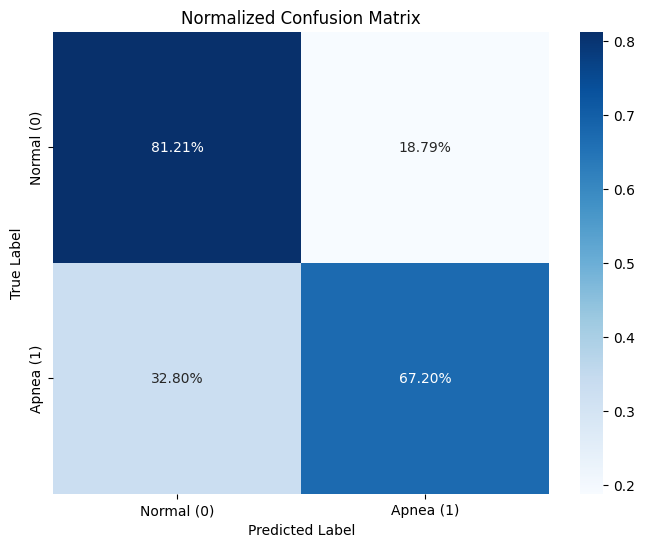

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Evaluating final model on the test set...")

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Classification Report and Confusion Matrix ---
print('\nClassification Report')
print('---------------------')
class_names = ['Normal (0)', 'Apnea (1)']
print(classification_report(all_labels, all_preds, target_names=class_names))

print('Confusion Matrix')
print('----------------')
cm = confusion_matrix(all_labels, all_preds)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm, annot=True, fmt='.2%', cmap='Blues', 
    xticklabels=class_names, yticklabels=class_names
)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

*Leave one out Cross validation*

Starting Leave-One-Night-Out cross-validation with 9 folds...

--- FOLD 1/9 (Testing on Night: 04-04-2025) ---
  - Original training distribution: Counter({np.int64(0): 24608, np.int64(1): 709})
  - Resampled training distribution: Counter({np.int64(0): 24608, np.int64(1): 24608})
  - Early stopping triggered at epoch 8.
  - Training complete for fold 1.
  - Evaluation complete for fold 1.

--- FOLD 2/9 (Testing on Night: 05-04-2025) ---
  - Original training distribution: Counter({np.int64(0): 24997, np.int64(1): 607})
  - Resampled training distribution: Counter({np.int64(0): 24997, np.int64(1): 24997})
  - Early stopping triggered at epoch 11.
  - Training complete for fold 2.
  - Evaluation complete for fold 2.

--- FOLD 3/9 (Testing on Night: 08-05-2025) ---
  - Original training distribution: Counter({np.int64(0): 24618, np.int64(1): 845})
  - Resampled training distribution: Counter({np.int64(0): 24618, np.int64(1): 24618})
  - Early stopping triggered at epoch 8.
  - Training c

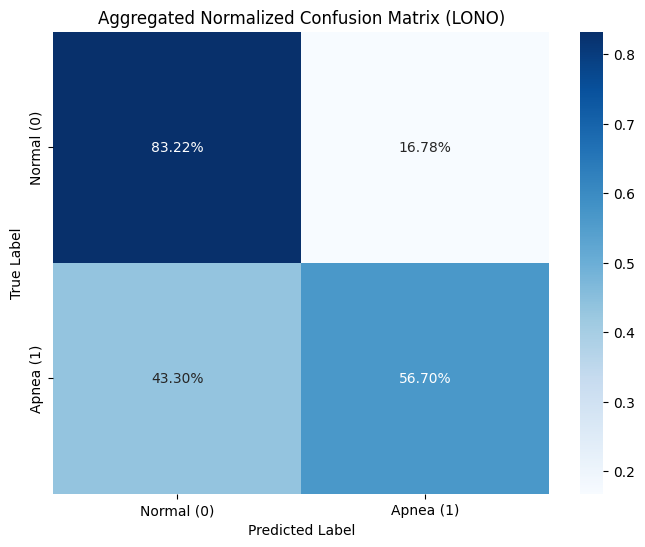

In [14]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# --- We need the EarlyStopping class again for this cell ---
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# --- Main LONO Loop ---
all_fold_predictions = []
all_fold_true_labels = []

logo = LeaveOneGroupOut()
n_folds = logo.get_n_splits(groups=groups)
print(f"Starting Leave-One-Night-Out cross-validation with {n_folds} folds...\n")


# --- Loop through each fold ---
for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    
    test_night = np.unique(groups[test_idx])[0]
    print(f"--- FOLD {fold + 1}/{n_folds} (Testing on Night: {test_night}) ---")

    # Split the data for this fold
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Balance the TRAINING data for this fold using 1:1 SMOTE
    print(f"  - Original training distribution: {Counter(y_train)}")
    nsamples, n_timesteps, n_features = X_train.shape
    X_train_reshaped = X_train.reshape((nsamples, n_timesteps * n_features))
    
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, y_train)
    X_train_resampled = X_train_resampled.reshape(-1, n_timesteps, n_features)
    print(f"  - Resampled training distribution: {Counter(y_train_resampled)}")

    # Create PyTorch DataLoaders for this fold
    X_train_tensor = torch.from_numpy(X_train_resampled).float()
    y_train_tensor = torch.from_numpy(y_train_resampled).long()
    X_test_tensor = torch.from_numpy(X_test).float()
    y_test_tensor = torch.from_numpy(y_test).long()
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor) # This is our validation set for the fold
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Initialize a NEW model for this fold
    model = OSA_CNN(n_features=n_features, n_outputs=2).to(device)
    
    # --- ADDED: Optimizer with scheduler and Early Stopping for this fold ---
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
    criterion = nn.CrossEntropyLoss()
    early_stopping = EarlyStopping(patience=7, verbose=False, path=f'lono_checkpoint_fold_{fold}.pt')
    
    # Training loop for the current fold
    for epoch in range(EPOCHS):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # --- ADDED: Validation phase inside the fold's training loop ---
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)
        early_stopping(avg_val_loss, model)
        
        if early_stopping.early_stop:
            print(f"  - Early stopping triggered at epoch {epoch + 1}.")
            break

    print(f"  - Training complete for fold {fold + 1}.")
            
    # --- Load the BEST model weights for this fold before evaluating ---
    model.load_state_dict(torch.load(f'lono_checkpoint_fold_{fold}.pt'))

    # Evaluate the fold and store results
    model.eval()
    fold_preds = []
    with torch.no_grad():
        for inputs, _ in val_loader: 
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            fold_preds.extend(predicted.cpu().numpy())
            
    all_fold_predictions.extend(fold_preds)
    all_fold_true_labels.extend(y_test)
    print(f"  - Evaluation complete for fold {fold + 1}.\n")


# --- FINAL AGGREGATED EVALUATION ---
print("\n====================================================")
print("Leave-One-Night-Out Cross-Validation Complete.")
print("Aggregated Results Across All Folds:")
print("====================================================")

class_names = ['Normal (0)', 'Apnea (1)']
print(classification_report(all_fold_true_labels, all_fold_predictions, target_names=class_names, zero_division=0))

cm = confusion_matrix(all_fold_true_labels, all_fold_predictions)
row_sums = cm.sum(axis=1)[:, np.newaxis]
with np.errstate(divide='ignore', invalid='ignore'):
    cm_norm = np.where(row_sums > 0, cm.astype('float') / row_sums, 0)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm, annot=True, fmt='.2%', cmap='Blues', 
    xticklabels=class_names, yticklabels=class_names
)
plt.title('Aggregated Normalized Confusion Matrix (LONO)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()